# Writing a dog breed detector with neural networks

Please note that this notebook uses material presented in the [Udacity Nanodegree Artificial Intelligence course](https://www.udacity.com/ai)

## Neural network quickstart

Neural networks in a simplified view can be seen as approximators of a function. 

As an example, we can have a set of points in 2D space specified by their position [x, y]. Lets say, that we split the points into two groups - some of them will be red (or 0) and some of them blue (or 1). This set of points we will call our input data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt                        
%matplotlib inline

input_data = np.loadtxt(open("data.csv", "rb"), delimiter=",")

How does the data look like?

In [2]:
print(input_data[:5])
print(input_data[-5:])

[[ 0.78051  -0.063669  1.      ]
 [ 0.28774   0.29139   1.      ]
 [ 0.40714   0.17878   1.      ]
 [ 0.2923    0.4217    1.      ]
 [ 0.50922   0.35256   1.      ]]
[[ 0.77029  0.7014   0.     ]
 [ 0.73156  0.71782  0.     ]
 [ 0.44556  0.57991  0.     ]
 [ 0.85275  0.85987  0.     ]
 [ 0.51912  0.62359  0.     ]]


We can actually visualise the data in a graph, with their X and Y positions, and the value will be used to determine the colour for the point:

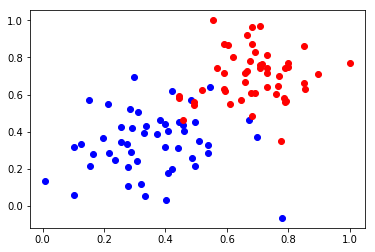

In [3]:
def show_points():    
    c = ["ro", "bo"]
    for i in range(0, len(input_data)):
        plt.plot(input_data[i, 0], input_data[i, 1], c[int(input_data[i, 2])])
        
show_points()
plt.show()

We have a new point, which is not in the original set of points. And we would like to know, if this point should be blue or red?

This is actually a classification task - based on some input data, we would like to predict into which group the new data belongs.

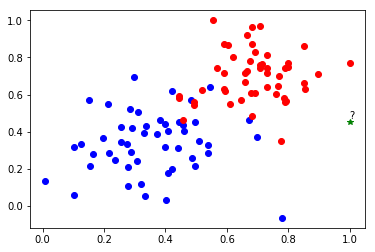

In [5]:
def sample_point(point):
    plt.plot(point[0], point[1], 'g*')
    plt.annotate('?', xy=point, xytext=(point[0], point[1] + 0.02))
    
sample_point([1, 0.45])
show_points()
plt.show()

One way how we can actually solve the task is to split the data by a line, for example like this:

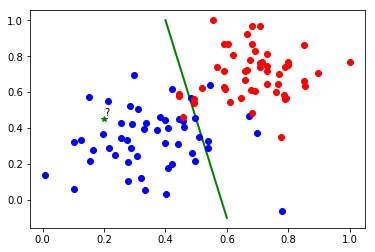

In [6]:
plt.plot([0.6, 0.4], [-0.1, 1], color='g', linestyle='-', linewidth=2)
show_points()
sample_point([0.2, 0.45])
plt.show()

Based on the line above, when we have a new point we can say:
- if the point is left of our line, it should be blue
- if the point is right of our line, it should be red

We can already see above that the line we used is not the best approximation - some red points are actually left of the line, and some of the white points are to the right. This actually happens almost always with real data - they cannot be simply split into groups, some of the data will be classified as errors. Therefore we would like to find a line, that matches the input data to have the least errors, so we can also do predictions with least errors possible.

Now a little math. Any line (even our sample line) can be expressed as:
$$
a*x + b*y + c = 0
$$

Now when we have a point, to tell whether it is red or blue, we can actually use a different expressions:
$$
Red point: a*x + b*y + c < 0
$$
$$
Blue point: a*x + b*y + c > 0
$$

Now rewrite the line expression a little. We use w1, w2 instead of a, b, because these are so called weights. Instead of c we will use b, as this is called bias. And instead of (x, y) we will use just (x1, x2) as these are our data:
$$
w1*x1 + w2*x2 + b = 0
$$

The question on whether the data is left or right of the line (lower or greater than 0) - this question is called "Activation function". Our "equation" will be active when the the result of the equation is above 0, and non active when the result of the equation is bellow 0.

With f as our activation function, we can have the prediction written as:
$$
output = f(w1*x1 + w2*x2 + b)
$$

And this is actually a very simple neuron called perceptron. It can be visualised for example like this:

![Perceptron](images/perceptron.png)

Lets do another rewrite of the expression, the last one - we are going to write the equation with matrixes:

\begin{equation*}
\mathbf{output} = \mathbf{f} ( \begin{vmatrix}
\mathbf{w}_1 & \mathbf{w}_2 & \mathbf{b} 
\end{vmatrix} \times 
\begin{vmatrix}
\mathbf{x}_1 \\
\mathbf{x}_2 \\
\mathbf{1}
\end{vmatrix}
) 
\end{equation*}

Or just with matrices:
\begin{equation*}
\mathbf{output} = \mathbf{f} ( \mathbf{W} \times \mathbf{X} )
\end{equation*}

Here you can see that neural networks are actually matrix operations. That's why we need special processors for neural nets and their training - like graphic cards, because they are specialized on this task.

Now we can create a perceptron in code:

In [10]:
# Function for the line
def line_function(X, W, b):
    return (np.matmul(X,W)+b)

sample_X = [0.2, 0.2]
sample_W = [-0.2, -0.1]
sample_bias = 0.5

# Example for point 0.2, 0.2 with weights 0.1, 0.1 and bias 0.4
line_function(sample_X, sample_W, sample_bias)

0.44

When we have a line function, we can combine it with activation to create a perceptron:

In [11]:
def activation(value):
    if value >= 0:
        return 1
    return 0

def perceptron(X, W, b):
    return activation(line_function(X, W, b))

perceptron(sample_X, sample_W, sample_bias)

1

Now how to actualy choose the weights and bias for our perceptron?

Neural networks are algorithms trained on data. We take a point, run it through the perceptron, see if the prediction matches and if not we adjust the weights and bias. How much we adjust them? Well we will adjust them based on a constant called learning rate. As our initial weights we can take anything, so lets make them random.

In [13]:
X = input_data[:, 0:2]
y = input_data[:, 2]

x_min, x_max = min(X[:, 0]), max(X[:, 0])
y_min, y_max = min(X[:, 1]), max(X[:, 1])

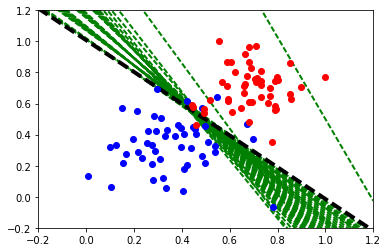

In [16]:
np.random.seed(16)

# We define single step that goes through all the values
# and adjust the weights and biases for points which are wrongly classified
def perceptronStep(X, y, W, b, learn_rate = 0.01):

    for i in range(X.shape[0]):
        outcome = perceptron(X[i], W, b)
        
        if outcome != y[i]:
            if outcome == 0:
                W = W + X[i][:, None] * learn_rate
                b = b + learn_rate
            else:
                W = W - X[i][:, None] * learn_rate
                b = b - learn_rate

    return W, b

# We iterate through the single adjust step specified number of times
def trainPerceptronAlgorithm(X, y, learn_rate = 0.01, num_epochs = 40):
    # initialize random weights and bias
    W = np.array(np.random.rand(2,1))
    b = np.random.rand(1)[0] + x_max
    
    boundary_lines = []
    for i in range(num_epochs):
        # In each epoch, we apply the perceptron step.
        W, b = perceptronStep(X, y, W, b, learn_rate)
        boundary_lines.append((-W[0]/W[1], -b/W[1]))
    return boundary_lines    

# Get all lines that were calculated so far and show them on a graph
boundary_lines = trainPerceptronAlgorithm(X, y)

def plot_line(a, b, color = 'g', linewidth = 2):
    plt.plot([-0.2, 1.2], [a*-0.2 + b, a*1.2 + b], color=color, linestyle='--', linewidth=linewidth)
    
for i in range(len(boundary_lines)):
    color = 'g'
    if i == len(boundary_lines) - 1:
        plot_line(boundary_lines[i][0], boundary_lines[i][1], 'black', 4)
    else:
        plot_line(boundary_lines[i][0], boundary_lines[i][1])
    
show_points()
axes = plt.gca()
axes.set_xlim([-0.2,1.2])
axes.set_ylim([-0.2,1.2])
plt.show()


This was very simplified learning - in real neural networks there are two major changes to this.

In real neural networks we are calculating the error of the real outputs and predicted outputs. Based on these we calculate so called loss function - and this one we try to minimize during the training.

To minimize the loss function, we are typically using an algorithm called Gradient Descent. The idea behind it is that we adjust the weights to find the minimal loss function based on its derivations and learning rate applied to the neurons which were activated during the training step.

## Multilayer neural network

Now we have our single perceptron with two inputs. We can now do multiple things.

We can add more inputs:

![Perceptron](images/more_inputs.png)

It will allow us to actually use more features for our perceptron - e.g. we might want to predict what is the probability of having grade A on a test based on the following features:
- hours of study
- previous attempts
- number of lectures visited
- points from excercises
- etc.

We can also add more neurons - so you create what is called a fully connected layer in neural network:

![FullyConnected](images/fully_connected_layer.png)

We can now predict multiple marks.

And last but not least, we can actually add more layers:

![FullyConnected](images/multi_layer.png)

This will actually allow us to do simulate non linear functions and actually better match our training data.

## Activation Functions

So far we have left out the magical function F and in our simulated network it was simple:
- if higher than 0, then return 1
- if lower than 0, then return 0

But in real neural networks we need to use continous functions, not just true false. The most common functions include:

### Sigmoid

The sigmoid function is a continuous equivalent of our true / false function, used when you need this kind of outcome from the neural network or its layer.

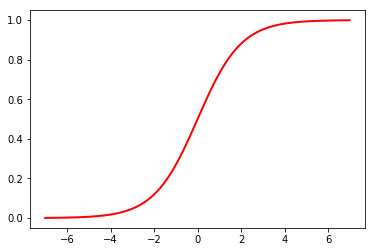

In [17]:
def sigmoid(x):
    return 1. / (1. + np.exp(-(x)))

x = np.arange(-7, 7, .01)
S = sigmoid(x)
plt.plot(x, S, color='red', lw=2)
plt.show()

### ReLU

The ReLU (Rectifier) function returns either the maximum from (value, 0) - so for values less than 0, it returns 0. This function is commonly used in convolutional neural networks.

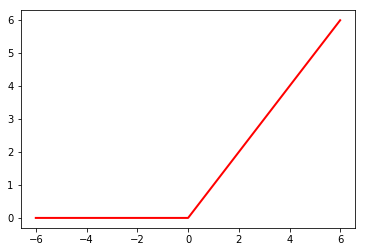

In [18]:
def relu(x):
    return np.maximum(x, 0)
    
x = np.arange(-6, 6, .01)
S = relu(x)
plt.plot(x, S, color='red', lw=2)
plt.show()

### Softmax function

Another very common function, which is typically used in the output layers of the neural network - especially for classification tasks. Imagine that you have 3 outcomes from the neural networks (three perceptrons in the final layers). But the outcomes are real numbers, of any size (typically larger than 0). What softmax does is that it puts all the numbers into interval (0, 1), and that all the values together sum as 1. This allows you to treat the values as probabilities of the outcome.

\begin{equation*}
\mathbf{softmax} ( \begin{vmatrix}
\mathbf{5} \\
\mathbf{7} \\
\mathbf{8} \\
\end{vmatrix} ) =
\begin{vmatrix}
\mathbf{0.25} \\
\mathbf{0.35} \\
\mathbf{0.4}
\end{vmatrix}
\end{equation*}

## Convolutional neural networks

Now we have seen the basic type of neural network. What if we would like to use it to detect what is in an image? It might look for example like this:

![ImagePerceptrons](images/image_perceptron.png)

Here we will flatten the image pixels into an array, which we will use as input to our fully connected neural network. This migth work, but we are in fact loosing a lot of information - the information of which pixels are close to each other. This information is in fact very important for analysing what is in the image. 

This is where the convolutional layers come in play. They are analyzing the pixels as they appear in the image. Every perceptron in a convolution layer is conected to few close pixels in the image like this:

![ConvolutionOne1](images/convolution_1.png)

We can create a whole layer of perceptrons, which are grouped like this:

![ConvolutionFilter](images/convolutional_filter.png)

This kind of arangement creates a "filter", which looks for a specific pattern in the image. A single convolutional layer actualy contains more than one of these filters - different filters are trained to recognize different patterns inside the image. These filters actually can be visualised like [here](http://cs231n.github.io/understanding-cnn/).

Now we can add more convoltional layers. It is typical that the higher layers have more filters than the layers bellow:

![ConvolutionLayers](images/convolutional_layers.png)

The first convolutional layer detects simple patterns in the image - like lines, small circles etc. The next layers detects more complex patterns, combined from the simple patterns of the layers bellow. The final layers can actually detect large scale image parts - which might be whole objects or faces for example. Thats why the higher layers need more filters - they are more and more specific. 

## Detecting dogs in images

Finaly we have the basic theory that we need to recognize images. So lets start recognizing dogs :) First we load the training, testing and validation data

In [19]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


We need to preprocess the image data, mainly divide all values by 255, to have values between 0 and 1

In [20]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:15<00:00, 53.51it/s]


Lets define a sample model with Keras. Keras is a framework wrapping Tensorflow (or it can wrap Theano), and has high level functions for definition of the neural networks layers

In [21]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(16,(3,3), padding='same', input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       73856     
__________

Now lets compile our model

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

And train it (takes lot of time :) )

In [23]:
from keras.callbacks import ModelCheckpoint  

epochs = 1

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/1
6680/6680 [==============================] - 329s - loss: 4.8779 - acc: 0.0109 - val_loss: 4.8301 - val_acc: 0.0156


During training, we have saved the models after each epoch, and now we want to load the best one

In [24]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

Lets test it on the test data set to see what is the accuracy.

In [25]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.7943%


## Using Inception model

Not a very good accuracy right? A good news is that there are many models which are quite good for recognizing images. An example of such model is the [InceptionV3](https://arxiv.org/abs/1512.00567) model, that was trained to recognize ImageNet database into 1000 classes. We can actually take this model, cut off the last decisioning part, and use just the convolutional layers for detecting features in the images. We will then add additional fully connected layer to these images which will be trained to recognize just dog breeds from features discovered by Inception.

Pretty cool right? Lets start, we have already a training set of features that were generated by the InceptionV3, we take this as input for our last layer.

In [26]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

Lets define the architecture of the last layer. There are 133 dog breeds that we are detecting, so the final layer is a softmax dense layer

In [27]:
from keras.layers import AveragePooling2D

Inception_model = Sequential()

Inception_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))

Inception_model.add(Dropout(0.25))
Inception_model.add(Dense(133, activation='softmax'))

Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


Now compile and train or model. You can see that the training is much faster than before

In [28]:
### TODO: Compile the model.
# SGD has better outcomes than RMSprop
Inception_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


In [29]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

Inception_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s - loss: 2.5682 - acc: 0.4864 - val_loss: 1.0659 - val_acc: 0.7509
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.8981 - acc: 0.7746 - val_loss: 0.6930 - val_acc: 0.8180
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.6630 - acc: 0.8198 - val_loss: 0.5987 - val_acc: 0.8335
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.5505 - acc: 0.8485 - val_loss: 0.5447 - val_acc: 0.8443
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.4857 - acc: 0.8629 - val_loss: 0.5174 - val_acc: 0.8467
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.4326 - acc: 0.8711 - val_loss: 0.5084 - val_acc: 0.8407
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.3965 - acc: 0.8879 - val_loss: 0.4947 - val_acc: 0.8455
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 0.3689 - ac

As before, load the best model that was trained

In [30]:
Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')

And test its accuraccy

In [31]:
### TODO: Calculate classification accuracy on the test dataset.
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0144%


Nice, above 80% and we didn't actually have to do that much. Lets try it, first use couple of helper functions for loading the image and detecting with the trained model

In [32]:
from extract_bottleneck_features import *

def Inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [33]:
import cv2

def breed_detector(img_path):
    print('What might you be ... ?')
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(cv_rgb)
    plt.show()
    
    print('You look like a ...')
    print(Inception_predict_breed(img_path))

And we can detect dogs now

What might you be ... ?


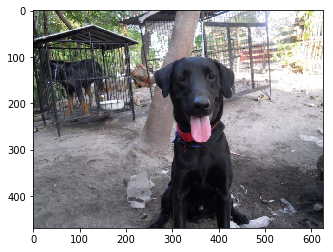

You look like a ...
Labrador_retriever


In [34]:
breed_detector('images/Labrador_retriever_06449.jpg')

What might you be ... ?


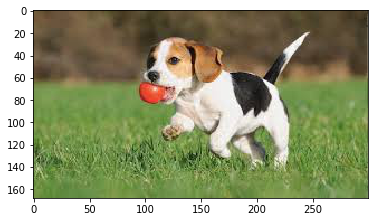

You look like a ...
American_foxhound


In [35]:
breed_detector('images/test/beagle.jpeg')

What might you be ... ?


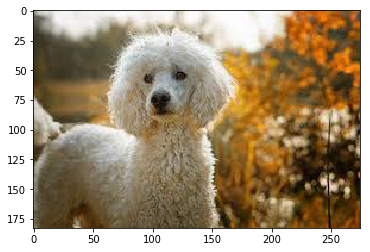

You look like a ...
Poodle


In [36]:
breed_detector('images/test/poodle.jpeg')

What might you be ... ?


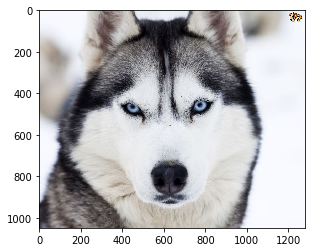

You look like a ...
Alaskan_malamute


In [37]:
breed_detector('images/test/husky.jpg')

What might you be ... ?


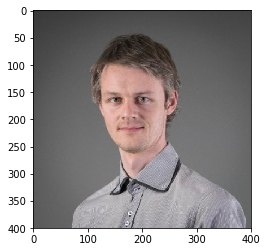

You look like a ...
Boykin_spaniel


In [38]:
breed_detector('images/vladimir_hlavacek.jpg')

What might you be ... ?


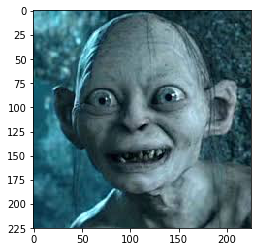

You look like a ...
Akita


In [39]:
breed_detector('images/glum.jpeg')

What might you be ... ?


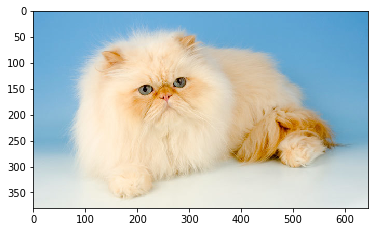

You look like a ...
Brussels_griffon


In [40]:
breed_detector('images/test/cat.jpeg')